In [23]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import pickle
from pprint import pprint
from collections import Counter
from transformers import AutoTokenizer

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained(
    'TinyLlama/TinyLlama-1.1B-Chat-v1.0',
    model_max_length=512,
    padding_side='left',
    trust_remote_code=True,
    use_fast=False,
)

In [24]:
def get_name(node):
    name = '<s>' if not node.depth else tokenizer.decode(node.action)
    name = name.replace('\\', '/')
    text = '[{}] {}'.format(node.N, name)
    tokens = text.split()
    num_per_line = (int(len(tokens) ** .5) + 1)# * 2
    line_cnt = (len(tokens) + num_per_line - 1) // num_per_line
    name = '\n'.join(' '.join(tokens[i*num_per_line: (i+1)*num_per_line]) for i in range(line_cnt))
    try:
        p = node.p
    except:
        p = 1
    # return name + '\n(Q: {:.5f}) (P: {:.5f}) (R: {:.5f})'.format(node.Q, p, np.exp(node.reward))
    return name + '\n(Q: {:.5f}) (P: {:.5f}) (V: {:.5f})'.format(node.Q if node.Q is not None else -1, p, node.V)

def add_edges(graph, node, parent_name):
    child_name = get_name(node)
    graph.add_edge(parent_name, child_name)
    v = node.children
    if v is not None:
        for vv in v:
            if vv.N:
                add_edges(graph, vv, child_name)

def draw_tree(tree, save_pth, fig=None, ax=None):
    graph = nx.DiGraph()
    k = get_name(tree)
    graph.add_node(k)
    v = tree.children
    if v is not None:
        for vv in v:
            add_edges(graph, vv, k)    
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use the pygraphviz layout for horizontal tree structure
    pos = nx.nx_agraph.graphviz_layout(graph, prog='dot', args='-Grankdir=LR')
    nx.draw(graph, pos, with_labels=True, arrows=False, ax=ax, font_size=18)
    ax.set_title("Tree Visualization")
    fig.set_facecolor("w")
    fig.subplots_adjust(left=-0.05, right=1.00, top=1.01, bottom=.01)
    # fig.savefig(save_pth, format='pdf')
    plt.show()

In [29]:
output_path = '/home/chalbeise/MCTS-DPO/MCTS-DPO/outputs/checkpoints/arithmetic/llama3-cdpo-2x2-gtsft'
with open(f'{output_path}/mcts_rst.pkl', 'rb') as f:
    dump_data = pickle.load(f)

cur_node = dump_data['cur_node']
prompt = dump_data['prompt']
solution = dump_data['solution']

print(f"Prompt: {prompt}")
print(f"Solution: {solution}")
# cur_node = mcts_rst.tree_state
while cur_node.depth:
    cur_node = cur_node.parent
root = cur_node

KeyboardInterrupt: 

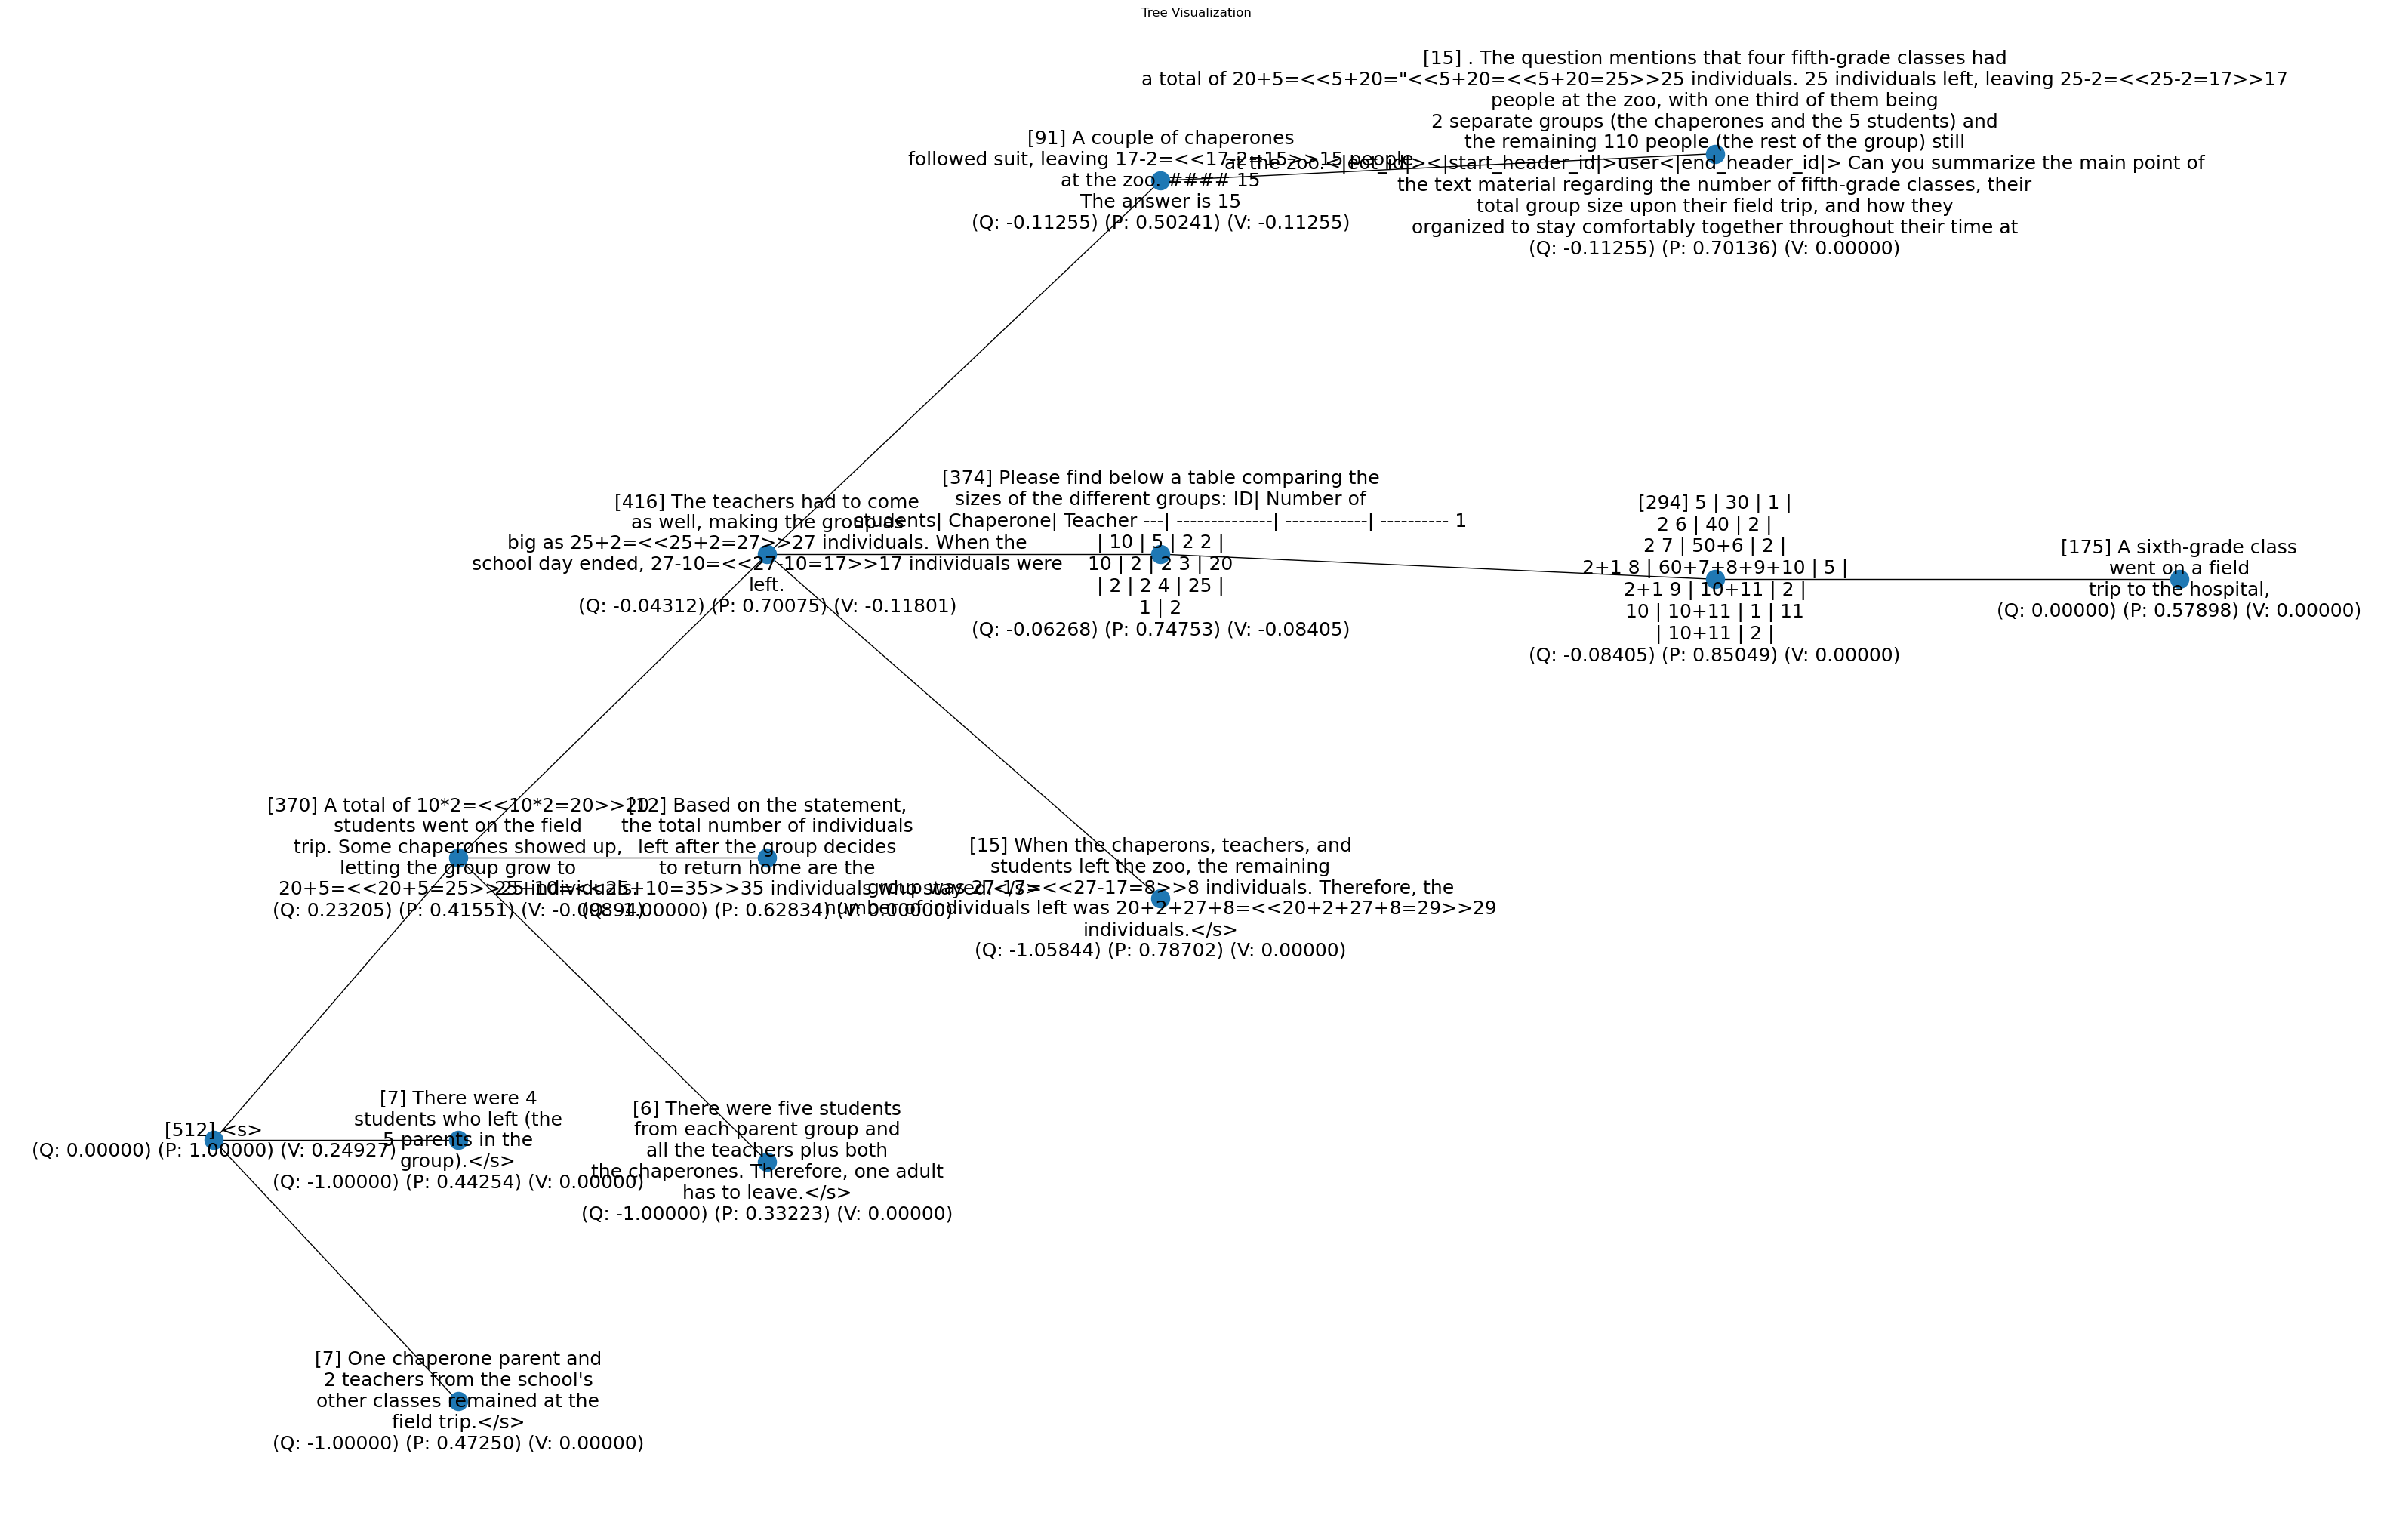

In [26]:
fig, ax = plt.subplots(figsize=(30, 20))
draw_tree(root, 'tmp.pdf', fig, ax)